# VCF - Parametric low-pass filter

This notebook focuses on the implementation aspects of the VCF, i.e. fixed word sizes and such.

A low pass filter where the following parameters are independently controllable:

- Cutoff frequency
- Resonance

References:
- Basic filter structure from Stilson and Smith 1996 Analyzing the Moog VCF with Considerations for Digital Implementation
- Referred to in Valimaki 2006 Oscillator and Filter Algorithms for Virtual Analog Synthesis page 26.

In [1]:
import os
import subprocess
import textwrap

import numpy as np
import matplotlib.pyplot as plt
from scipy import signal
import scipy.io.wavfile
from numba import jit

%load_ext fortranmagic
%load_ext Cython

def get_chirp(fs=44100, fstart=20, fstop=20e3, amplitude=2**15, duration_s=10):
    t = np.arange(duration_s*fs)/fs
    x = amplitude * signal.chirp(t, f0=fstart, f1=fstop, t1=max(t), method="linear")
    return np.array(x, dtype=np.int16)

def frequency_response(callback, cutoff, resonance,
                       fs=44100, fstart=20, fstop=20e3, amplitude=2**15):
    # Callback arguments:
    # - x:         Filter input (List[int16])
    # - length:    Length of x (int)
    # - cutoff:    Cutoff argument (0-127)
    # - resonance: Resonance argument (0-127)
    x = get_chirp(fs=fs, fstart=fstart, fstop=fstop, amplitude=amplitude, duration_s=10)
    y = callback(x, len(x), cutoff, resonance)
    f = np.linspace(fstart, fstop, len(y))
    #H = 1/amplitude * signal.hilbert(y)
    H = 1/amplitude * abs(np.array(y))
    return f, H

def decorate_frequency_response(yrange=[-50, 10]):
    fig, ax = plt.gcf(), plt.gca()
    ax.grid(True, "both", "both")
    ax.legend()
    ax.set_xlim(20, 20e3)
    ax.set_ylim(*yrange)
    fig.tight_layout()

/home/soren/.local/lib/python3.6/site-packages/fortranmagic.py:147: UserWarning: get_ipython_cache_dir has moved to the IPython.paths module since IPython 4.0.
  self._lib_dir = os.path.join(get_ipython_cache_dir(), 'fortran')


## Implementations

### Python

In [2]:
@jit
def nb_onepole(x, g, x1, y1):
    #v = 4*x/5 + x1/5
    v = 13*x/16 + 3*x1/16
    y = (v-y1)*g + y1
    return y

@jit
def map_cutoff(value):
    assert(0 <= value <= 127)
    b = 0.02
    a = (0.8-b) / (127*127)
    return a*value*value + b

@jit
def map_resonance(value):
    assert(0 <= value <= 127)
    b = 0.5
    a = (3.5-b) / 127
    return a*value + b
    
@jit
def vcf(x, length, cutoff, resonance):
    g = map_cutoff(cutoff)
    k = map_resonance(resonance)
    
    y = [0]*length
    w = [0, 0, 0, 0, 0] # Current sample
    d = [0, 0, 0, 0, 0] # Delayed sample
    
    # Feedback gain compensation form Valimaki
    G_comp = 0.5

    for n in range(1, length):     
        x_ = x[n]/16
        w[0] = x_ - (d[4]*k - G_comp*x_)
        w[1] = nb_onepole(w[0], g, d[0], d[1])
        w[2] = nb_onepole(w[1], g, d[1], d[2])
        w[3] = nb_onepole(w[2], g, d[2], d[3])
        w[4] = nb_onepole(w[3], g, d[3], d[4])

        for i in range(5):
            d[i] = w[i]

        y[n] = w[4]

    return y

### Fortran implementation

In [3]:
%%fortran -v

real function f_onepole(x, g, x1, y1)
    implicit none
    real, intent(in) :: x, g, x1, y1
    real :: v

    v = 1.0/1.3 * x + 0.3/1.3*x1
    f_onepole = (v-y1)*g + y1
end function

real function f_map_cutoff(midi)
    implicit none
    real, intent(in) :: midi
    real, parameter :: b = 0.02
    real, parameter :: a = (0.8-b) / (127*127)
    f_map_cutoff = a*midi*midi + b
end function

real function f_map_resonance(midi)
    implicit none
    real, intent(in) :: midi
    real, parameter :: b = 0.5
    real, parameter :: a = (3.5-b) / (127)
    f_map_resonance = a*midi + b
end function

subroutine f_vcf(x, length, cutoff, resonance, y)
    real, intent(in) :: cutoff, resonance
    integer, intent(in) :: length
    real, intent(in) :: x(:)
    real, intent(out) :: y(length)
    real, parameter :: G_comp = 0.5
    real :: w(5), d(5)
    real :: g, k, x_
    integer :: n

    g = f_map_cutoff(cutoff)
    k = f_map_resonance(resonance)
        
    w(:) = (/0, 0, 0, 0, 0/)
    d(:) = (/0, 0, 0, 0, 0/)
    
    do n = 1, size(x)
        x_ = x(n)/16.0
        w(1) = x_ - (d(5)*k - G_comp*x_)
        w(2) = f_onepole(w(1), g, d(1), d(2))
        w(3) = f_onepole(w(2), g, d(2), d(3))
        w(4) = f_onepole(w(3), g, d(3), d(4))
        w(5) = f_onepole(w(4), g, d(4), d(5))
        
        d(:) = w(:)
        y(n) = w(5)
    end do
end subroutine


Ok. The following fortran objects are ready to use: f_onepole, f_map_cutoff, f_map_resonance, f_vcf


### Cython

In [46]:
%%cython
cdef float cy_map_cutoff_float(int value):
    cdef float a, b
    b = 0.02
    a = (0.8-b) / (127*127)
    return a*value*value + b

cdef float cy_map_resonance_float(int value):
    cdef float a, b
    b = 0.5
    a = (3.5-b) / 127
    return a*value + b

cdef int cy_onepole(int x, float g, int x1, int y1):
    cdef int v
    #v = (13*(x>>4) + (3*(x1>>4)))
    #v = (14*x + 3*x1)>>4
    v = <int>(0.8*<float>x + 0.2*<float>x1)
    return <int>(<float>((v-y1)*g) + y1)

def cy_vcf(short[:] x, int length, int cutoff, int resonance):
    cdef float g, k
    cdef int[5] w
    cdef int[5] w1
    cdef int x_
    
    g = cy_map_cutoff_float(cutoff)
    k = cy_map_resonance_float(resonance)
    
    y = [0.0]*length
    w = [0, 0, 0, 0, 0] # Current sample
    w1 = [0, 0, 0, 0, 0] # Delayed sample

    for n in range(1, length): 
        x_ = x[n]
        
        w[0] = x_ - (<int>(<float>w1[4]*k) - (x_>>1)) # x>>1 = G_comp = 0.5 from Valimaki
        #w[0] = x_
        w[1] = cy_onepole(w[0], g, w1[0], w1[1])
        w[2] = cy_onepole(w[1], g, w1[1], w1[2])
        w[3] = cy_onepole(w[2], g, w1[2], w1[3])
        w[4] = cy_onepole(w[3], g, w1[3], w1[4])

        for i in range(5):
            w1[i] = w[i]

        # Limit resonance peaking
        y[n] = w[4] >> 4

    return y

## Parameter sweeps

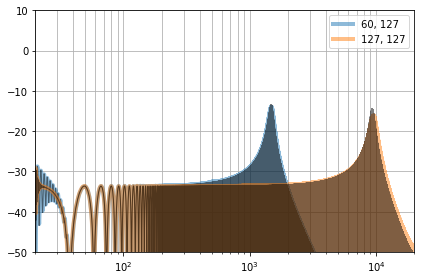

In [47]:
cutoffs = [60, 127]
resonances = [127]
for cutoff in cutoffs:
    for res in resonances:
        f, H = frequency_response(vcf, cutoff, res)
        plt.semilogx(f, 20*np.ma.log10(abs(H)), linewidth=4, alpha=0.5, label="{:d}, {:d}".format(cutoff, res))
        
        f, H = frequency_response(cy_vcf, cutoff, res)
        plt.semilogx(f, 20*np.ma.log10(abs(H)), color="k", linewidth=1, alpha=0.5)
decorate_frequency_response();

## Profiling

In [48]:
x = get_chirp()
%timeit -r3 -n3 vcf(x, len(x), 63, 63)
%timeit -r3 -n3 f_vcf(x, len(x), 63, 63)
%timeit -r3 -n3 cy_vcf(x, len(x), 63, 63)

25.4 ms ± 477 µs per loop (mean ± std. dev. of 3 runs, 3 loops each)
14.1 ms ± 271 µs per loop (mean ± std. dev. of 3 runs, 3 loops each)
27.3 ms ± 461 µs per loop (mean ± std. dev. of 3 runs, 3 loops each)


## Mapping cutoff and resonance as integers

In the filter structure, the midi parameters (0-127) are mapped to the internal parameters:

- `g` = Cutoff frequency (squared mapping from around 0.02 to 0.8)
- `k` = Resonance (linear mapping from around 0.5 to 3.5)

Calculations may be speeded up internally by using integer representations.

In [7]:
print("\n".join(textwrap.wrap("{}".format([int(np.floor(2**12*map_cutoff(X))) for X in range(128)]))))
print("\n".join(textwrap.wrap("{}".format([int(np.floor(2**12*map_resonance(X))) for X in range(128)]))))

[81, 82, 82, 83, 85, 86, 89, 91, 94, 97, 101, 105, 110, 115, 120, 126,
132, 139, 146, 153, 161, 169, 177, 186, 196, 205, 215, 226, 237, 248,
260, 272, 284, 297, 310, 324, 338, 353, 367, 383, 398, 414, 431, 448,
465, 483, 501, 519, 538, 557, 577, 597, 617, 638, 659, 681, 703, 725,
748, 771, 795, 818, 843, 868, 893, 918, 944, 971, 997, 1024, 1052,
1080, 1108, 1137, 1166, 1196, 1226, 1256, 1287, 1318, 1349, 1381,
1413, 1446, 1479, 1513, 1546, 1581, 1615, 1650, 1686, 1722, 1758,
1795, 1832, 1869, 1907, 1945, 1984, 2023, 2062, 2102, 2142, 2183,
2224, 2265, 2307, 2349, 2392, 2435, 2478, 2522, 2566, 2611, 2656,
2701, 2747, 2793, 2840, 2886, 2934, 2982, 3030, 3078, 3127, 3176,
3226, 3276]
[2048, 2144, 2241, 2338, 2435, 2531, 2628, 2725, 2822, 2918, 3015,
3112, 3209, 3305, 3402, 3499, 3596, 3692, 3789, 3886, 3983, 4079,
4176, 4273, 4370, 4466, 4563, 4660, 4757, 4853, 4950, 5047, 5144,
5240, 5337, 5434, 5531, 5627, 5724, 5821, 5918, 6014, 6111, 6208,
6305, 6402, 6498, 6595, 6692, 6789, 6885, 698